# ML Project End to End following Checklist for the Diamond Dataset 

## 1. Importing data and libraries

### Imports which we will continueosly update

In [112]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error,r2_score, accuracy_score, mean_absolute_error, explained_variance_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from sklearn.pipeline import Pipeline

### Set Random State for reproducibility

In [50]:
rng = np.random.RandomState(123)


### Load Data into DataFrame

In [51]:
df = pd.read_csv(
    r'C:/mle06/Machine Learning/Code/Thomas/Diamond Project/diamonds.csv'
    )


* Once you have downloaded the data, move it to your project directory, activate your virtualenv, and start the Jupyter local server.

### Look at first few rows and desciption of each attribute from documentation to help define problem statement

* Problem Statement is this case is "Build a Model to predict the price of a dimaond based of the feature attributes using Regression".




In [52]:
print(df.head())

   Unnamed: 0  carat      cut color clarity  depth  table  price     x     y  \
0           1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98   
1           2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84   
2           3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07   
3           4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23   
4           5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35   

      z  
0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75  



## 2. Exploratory Data Analysis with pandas and numpy


* Check for datatype of columns


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB



* Check for null values 

In [54]:
null_columns=df.columns[df.isnull().any()]
df.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

* Drop Unnamed Column

In [55]:
df = df.drop("Unnamed: 0", axis=1)

* Check for Outliers in Data

    * Drop data in x,y,z which equals 0: as its dimensionless

    * Visualise Data to observe outliers
    
    * Remove Outliers which stray away from other datapoints
        * x, y, z have dimensionless data so remove these.
        * Depth has outliers so cap this column
        * Table has outliers so cap this column


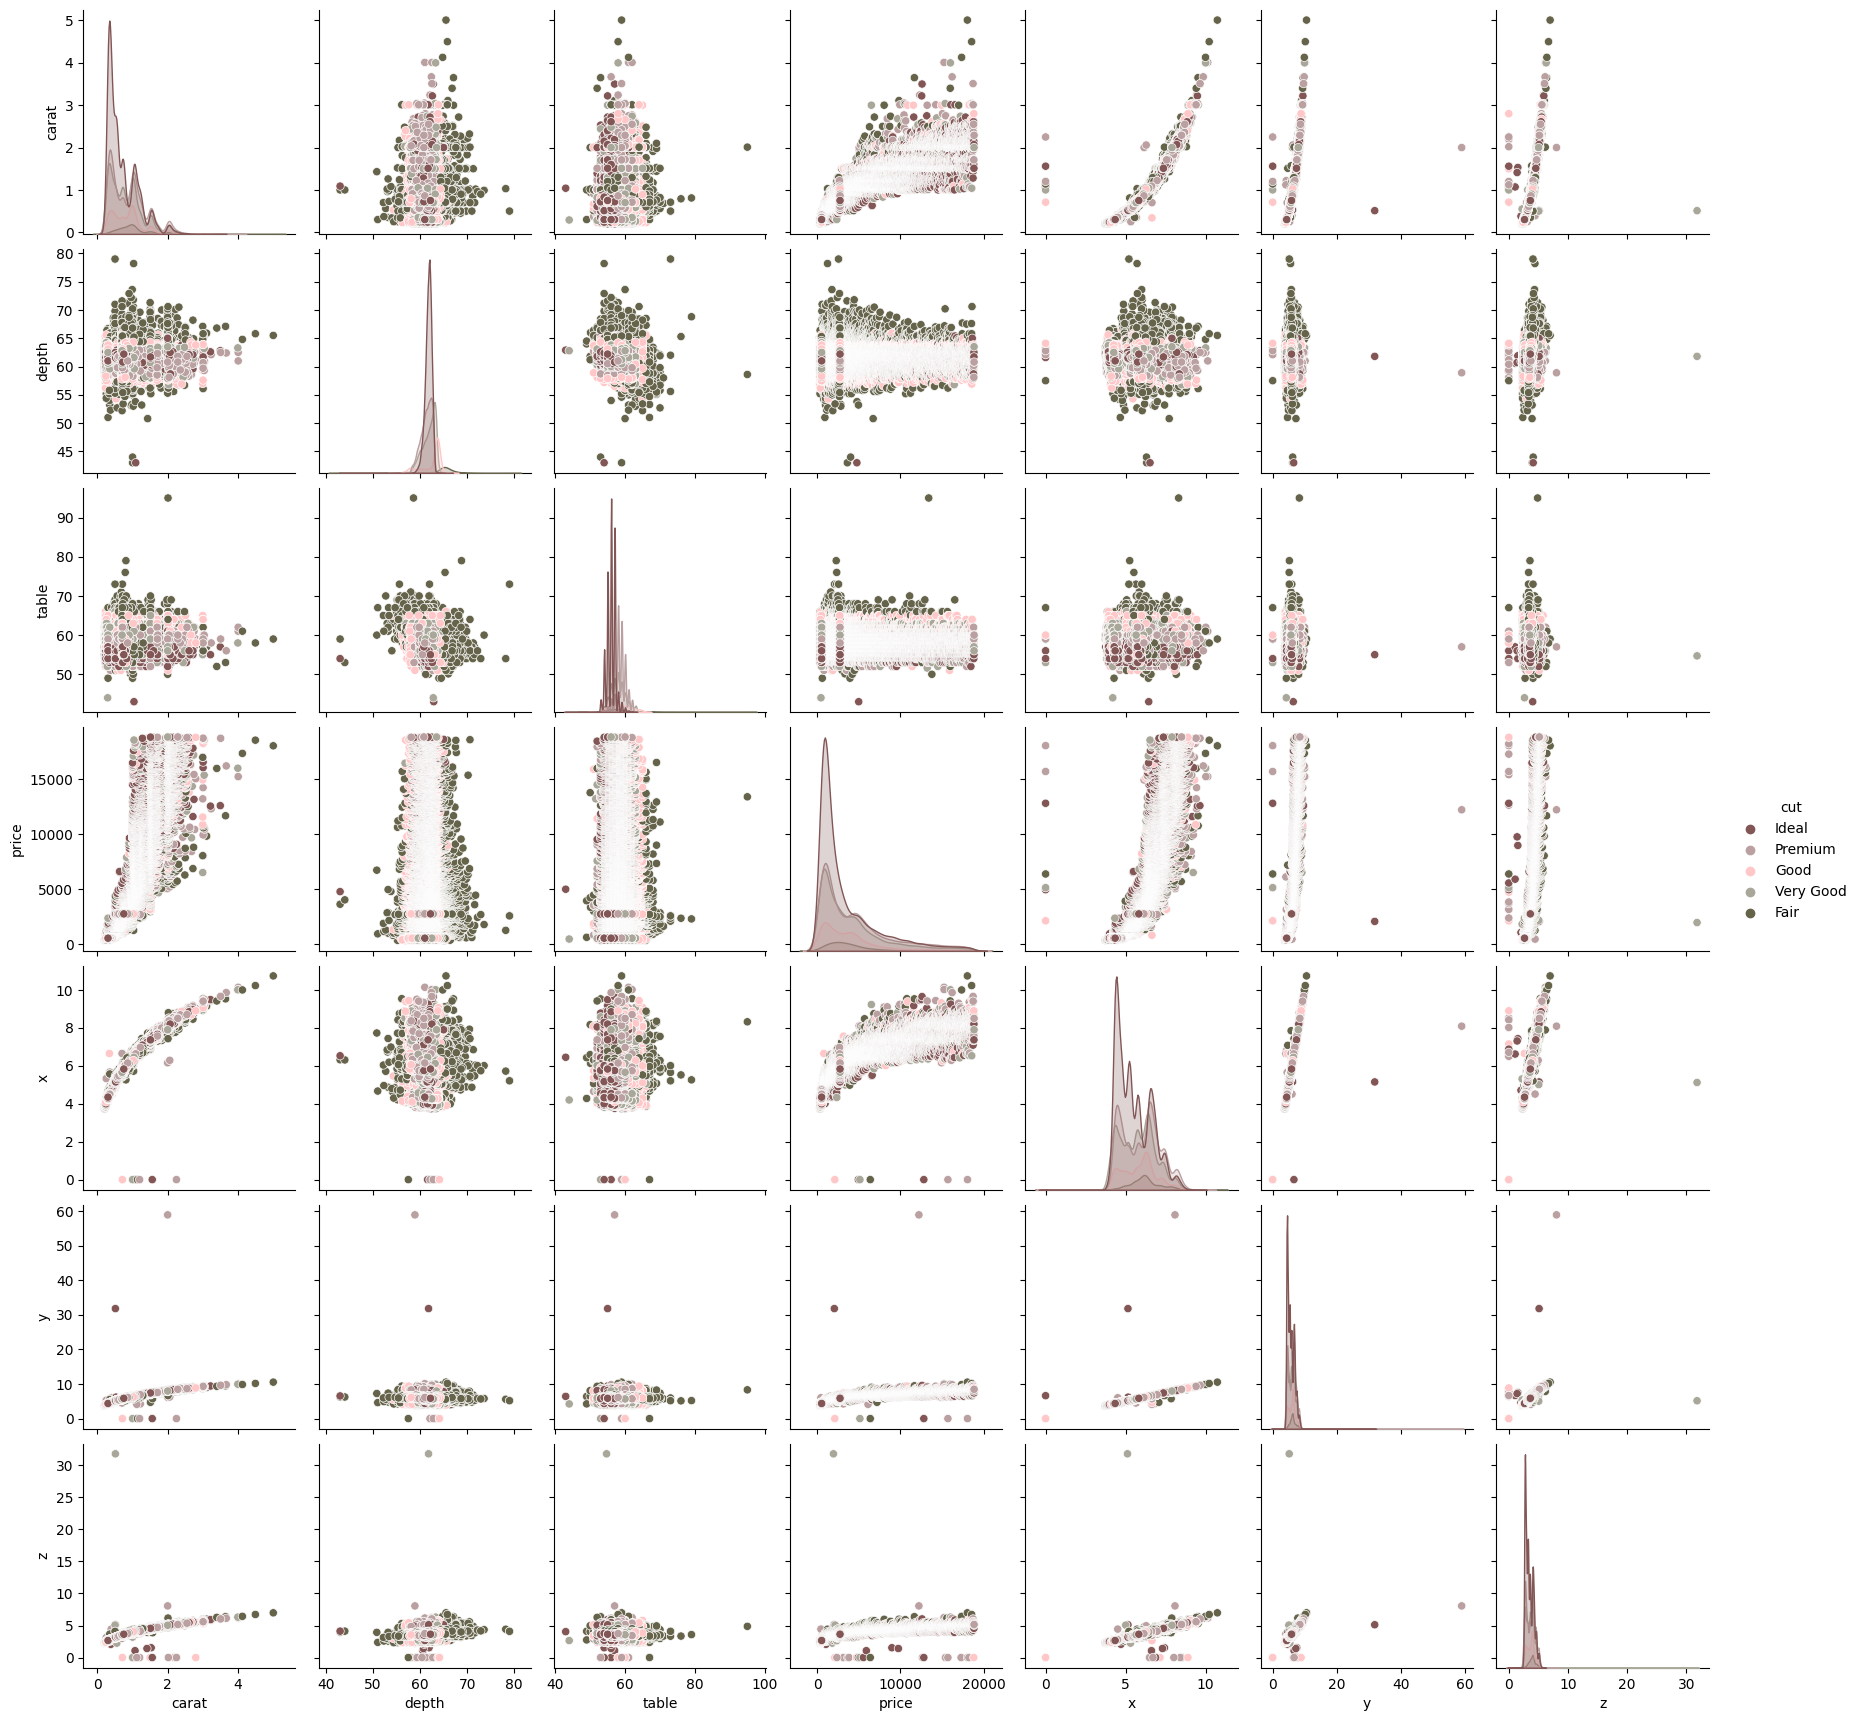

In [56]:
# Describe data
df.describe()
#Drop x,y,z which equal 0
df.drop(df[df["x"]==0].index)
df.drop(df[df["y"]==0].index)
df.drop(df[df["z"]==0].index)
#Pairplot of data to look at outliers
shade = ["#835656", "#baa0a0", "#ffc7c8", 
         "#a9a799", "#65634a"]#shades for hue
ax = sns.pairplot(df, 
                  hue= "cut",palette=shade)

In [57]:
#Dropping outliers
df = df[(df["depth"]<75)&(df["depth"]>45)]
df = df[(df["table"]<80)&(df["table"]>40)]
df = df[(df["x"]<30)]
df = df[(df["y"]<30)]
df = df[(df["z"]<30)&(df["z"]>2)]

* Look for categorical data distribution

In [58]:
df["cut"].value_counts() / len(df)

Ideal        0.399633
Premium      0.255607
Very Good    0.224090
Good         0.090934
Fair         0.029736
Name: cut, dtype: float64

In [59]:
df["color"].value_counts() / len(df)

G    0.209286
E    0.181646
F    0.176897
H    0.153895
D    0.125661
I    0.100544
J    0.052071
Name: color, dtype: float64

In [60]:
df["clarity"].value_counts() / len(df)

SI1     0.242251
VS2     0.227243
SI2     0.170367
VS1     0.151502
VVS2    0.093977
VVS1    0.067783
IF      0.033205
I1      0.013672
Name: clarity, dtype: float64

* Plot for correlation

C:\Users\ThomasMullan\AppData\Local\Temp\ipykernel_18060\4011500584.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat= df.corr()


<AxesSubplot: >

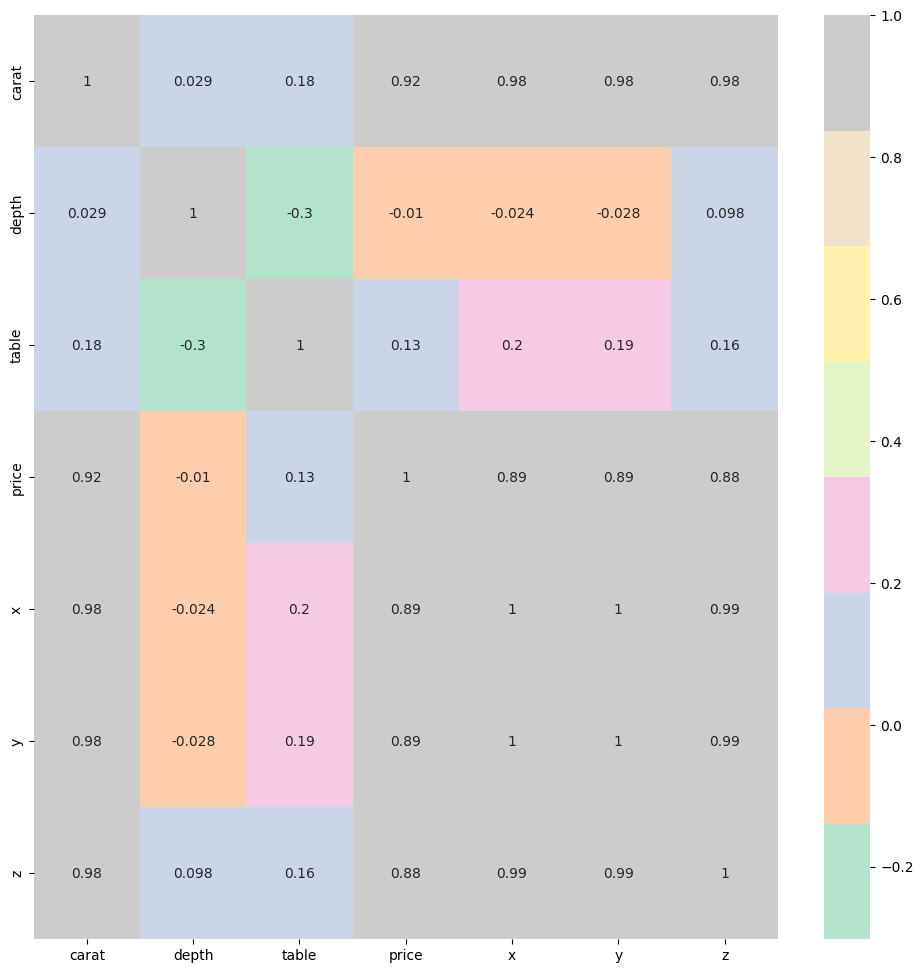

In [61]:
corrmat= df.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap="Pastel2",annot=True)

* Combining x,y,z and checking if correlation with price is stronger
    * We find that volume has stronger correlation than x,y,z

In [63]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z,Volume
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250
...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50,115.920000
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61,118.110175
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56,114.449728
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74,140.766120


In [64]:
df["Volume"] = df["x"] * df["y"] * df["z"]
corr_matrix = df.corr()
corr_matrix['price'].sort_values(ascending=False)
df = df.drop(columns=["x", "y", "z"], axis=1)
df

C:\Users\ThomasMullan\AppData\Local\Temp\ipykernel_18060\1011074881.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


,carat,cut,color,clarity,depth,table,price,Volume
0,0.23,Ideal,E,SI2,61.5,55.0,326,38.202030
1,0.21,Premium,E,SI1,59.8,61.0,326,34.505856
2,0.23,Good,E,VS1,56.9,65.0,327,38.076885
3,0.29,Premium,I,VS2,62.4,58.0,334,46.724580
4,0.31,Good,J,SI2,63.3,58.0,335,51.917250
...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,115.920000
53936,0.72,Good,D,SI1,63.1,55.0,2757,118.110175
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,114.449728
53938,0.86,Premium,H,SI2,61.0,58.0,2757,140.766120


* Scale Data with different ranges

In [66]:
# Define numerical variables to be standardized
numeric_data = ["carat", "depth", "table", "Volume"]
pipe = Pipeline([
    ('scaler', StandardScaler()),
])
# Fit and transform numeric data in df
df[numeric_data] = pipe.fit_transform(df[numeric_data])
df


* One Hot Encode Cat Variables

In [79]:
df['cut'] = df['cut'].map({'Ideal':1, 'Premium':2, 'Very Good':3, 'Good':4, 'Fair':5}).astype(int)

dummy = pd.get_dummies(df["color"], prefix="C_", drop_first=True)
df = pd.concat([df, dummy], axis=1)
df = df.drop("color", axis=1)

dummy1 = pd.get_dummies(df["clarity"], prefix="Cl_", drop_first=True)
df = pd.concat([df, dummy1], axis=1)
df = df.drop("clarity", axis=1)
df

,carat,cut,depth,table,price,Volume,C__E,C__F,C__G,C__H,C__I,C__J,Cl__IF,Cl__SI1,Cl__SI2,Cl__VS1,Cl__VS2,Cl__VVS1,Cl__VVS2
0,-1.198132,1,-0.175861,-1.103235,326,-1.198157,1,0,0,0,0,0,0,0,1,0,0,0,0
1,-1.240348,2,-1.372955,1.592022,326,-1.246505,1,0,0,0,0,0,0,1,0,0,0,0,0
2,-1.198132,4,-3.415055,3.388860,327,-1.199794,1,0,0,0,0,0,0,0,0,1,0,0,0
3,-1.071486,2,0.457894,0.244393,334,-1.086677,0,0,0,0,1,0,0,0,0,0,1,0,0
4,-1.029271,4,1.091650,0.244393,335,-1.018755,0,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,-0.163855,1,-0.668782,-0.204816,2757,-0.181565,0,0,0,0,0,0,0,1,0,0,0,0,0
53936,-0.163855,4,0.950815,-1.103235,2757,-0.152916,0,0,0,0,0,0,0,1,0,0,0,0,0
53937,-0.206070,3,0.739564,1.142812,2757,-0.200797,0,0,0,0,0,0,0,1,0,0,0,0,0
53938,0.131653,2,-0.527947,0.244393,2757,0.143436,0,0,0,1,0,0,0,0,1,0,0,0,0


* Change datatypes 

In [80]:
#df.astype('int').dtypes
df.dtypes

carat       float64
cut           int32
depth       float64
table       float64
price         int64
Volume      float64
C__E          uint8
C__F          uint8
C__G          uint8
C__H          uint8
C__I          uint8
C__J          uint8
Cl__IF        uint8
Cl__SI1       uint8
Cl__SI2       uint8
Cl__VS1       uint8
Cl__VS2       uint8
Cl__VVS1      uint8
Cl__VVS2      uint8
dtype: object

## 4. Split dataset into training and testing

In [81]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=rng)

X_train = df_train.drop("price", axis=1)
X_test = df_test.drop("price", axis=1)
y_train = df_train["price"]
y_test = df_test["price"]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (43125, 18)
y_train shape: (43125,)
X_test shape: (10782, 18)
y_test shape: (10782,)


## 5. Train Models

* Linear Regression
    * Shows us similar high scores on training and testing indicating that its not overfitting.
    * 92.02 % of variability of the prices can be explianed from the features selected.

    * Evaluate Model
        * MAE of +- 792.60 shows $ amount within of predicted price 

R Squared of LR on train set: 91.54%
R Squared of LR on test set: 92.02%


<AxesSubplot: xlabel='price'>

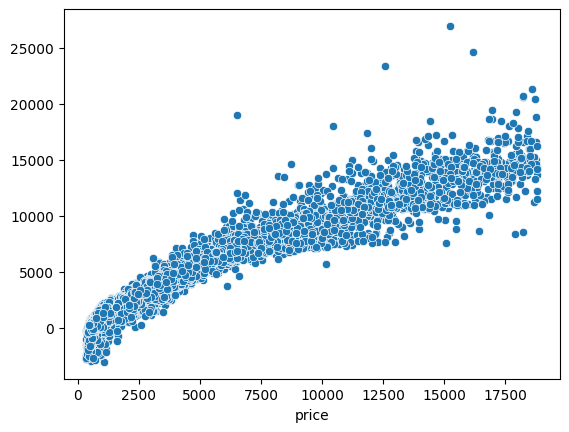

In [88]:
# Fitting model 
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
#R squared scores on training data (Check overfitting)
print("R Squared of LR on train set: {:.2%}".format(lr_model.score(X_train, y_train)))
print("R Squared of LR on test set: {:.2%}".format(lr_model.score(X_test, y_test)))
#Predict model and plot scatter cart of true and predicited values
y_pred = lr_model.predict(X_test)
sns.scatterplot(x=y_test, y=y_pred)



In [99]:
#Evualuation of lr_model
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error of LR Model on unseen data : {:.2f}".format(mae))

mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error of LR Model on unseen data : {:.2f}".format(np.sqrt(mse)))


Mean Absolute Error of LR Model on unseen data : 792.60
Root Mean Squared Error of LR Model on unseen data : 1130.16


* Decision Tree
    * Model seems to be genralising well to new data. 

R Squared of DT on train set: 99.99%
R Squared of DT on test set: 96.07%


<AxesSubplot: xlabel='price'>

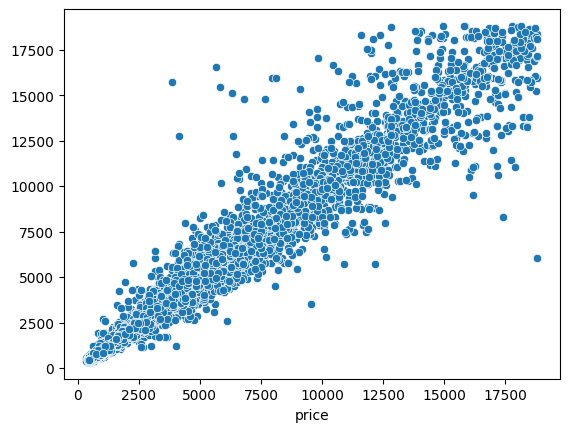

In [101]:
dt_model = DecisionTreeRegressor(random_state=rng)
dt_model.fit(X_train, y_train)

#R squared scores on training data (Check overfitting)
print("R Squared of DT on train set: {:.2%}".format(dt_model.score(X_train, y_train)))
print("R Squared of DT on test set: {:.2%}".format(dt_model.score(X_test, y_test)))
#Predict model and plot scatter cart of true and predicited values
y_pred1 = dt_model.predict(X_test)
sns.scatterplot(x=y_test, y=y_pred1)


In [102]:
#Evualuation of lr_model
mae = mean_absolute_error(y_test, y_pred1)
print("Mean Absolute Error of LR Model on unseen data : {:.2f}".format(mae))

mse = mean_squared_error(y_test, y_pred1)
print("Root Mean Squared Error of LR Model on unseen data : {:.2f}".format(np.sqrt(mse)))

Mean Absolute Error of LR Model on unseen data : 370.10
Root Mean Squared Error of LR Model on unseen data : 793.73


* Random Forest
    * Model seems to be genralising well to new data. 

R Squared of RF on train set: 99.67%
R Squared of RF on test set: 97.68%


<AxesSubplot: xlabel='price'>

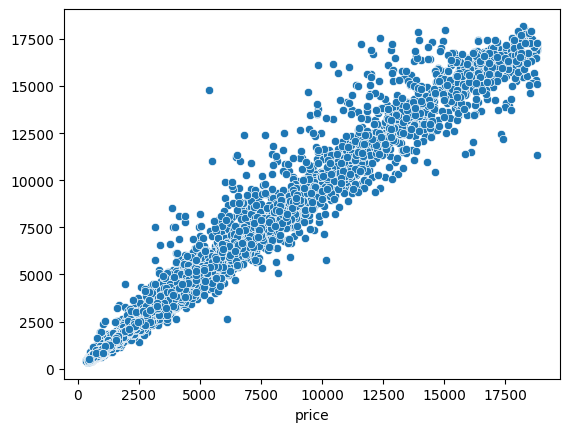

In [104]:
rf_model = RandomForestRegressor(random_state=rng)
rf_model.fit(X_train, y_train)

#R squared scores on training data (Check overfitting)
print("R Squared of RF on train set: {:.2%}".format(rf_model.score(X_train, y_train)))
print("R Squared of RF on test set: {:.2%}".format(rf_model.score(X_test, y_test)))
#Predict model and plot scatter cart of true and predicited values
y_pred2 = rf_model.predict(X_test)
sns.scatterplot(x=y_test, y=y_pred2)

In [108]:
#Evualuation of lr_model
mae = mean_absolute_error(y_test, y_pred2)
print("Mean Absolute Error of RF Model on unseen data : {:.2f}".format(mae))

mse = mean_squared_error(y_test, y_pred2)
print("Root Mean Squared Error of RF Model on unseen data : {:.2f}".format(np.sqrt(mse)))

Mean Absolute Error of RF Model on unseen data : 299.09
Root Mean Squared Error of RF Model on unseen data : 609.31


* XGBoost
    * Model seems to be genralising well to new data. 

R Squared of XGB on train set: 98.75%
R Squared of XGB on test set: 97.88%


<AxesSubplot: xlabel='price'>

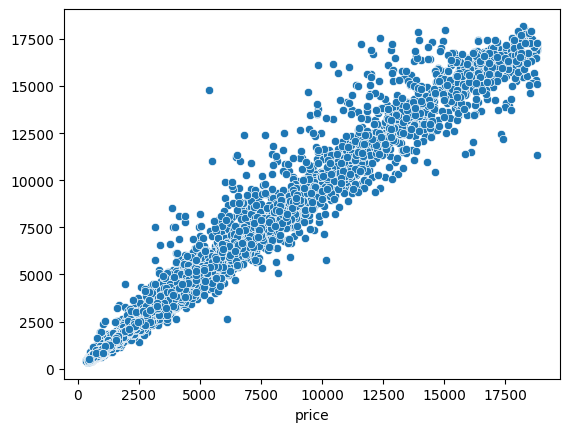

In [109]:
xgb_model = xg.XGBRegressor(random_state=rng)
xgb_model.fit(X_train, y_train)

#R squared scores on training data (Check overfitting)
print("R Squared of XGB on train set: {:.2%}".format(xgb_model.score(X_train, y_train)))
print("R Squared of XGB on test set: {:.2%}".format(xgb_model.score(X_test, y_test)))
#Predict model and plot scatter cart of true and predicited values
y_pred3 = rf_model.predict(X_test)
sns.scatterplot(x=y_test, y=y_pred3)

In [110]:
#Evualuation of lr_model
mae = mean_absolute_error(y_test, y_pred3)
print("Mean Absolute Error of XBG Model on unseen data : {:.2f}".format(mae))

mse = mean_squared_error(y_test, y_pred3)
print("Root Mean Squared Error of XGB Model on unseen data : {:.2f}".format(np.sqrt(mse)))

Mean Absolute Error of XBG Model on unseen data : 299.09
Root Mean Squared Error of XGB Model on unseen data : 609.31


## Fine Tuning Random Forest Model

* Using Grid Search to use cross validation

In [119]:

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True,
                           cv=10,
                          )

grid_search.fit(X_train, y_train)


GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_absolute_error')

In [120]:
best_params = grid_search.best_params_

In [121]:
rf_model = RandomForestRegressor(**best_params, random_state=rng)
rf_model.fit(X_train, y_train)

# R-squared scores on test data
print("R Squared of RF on train set: {:.2%}".format(rf_model.score(X_train, y_train)))
print("R Squared of RF on test set: {:.2%}".format(rf_model.score(X_test, y_test)))

# Evaluation of the final model
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error of RF Model on unseen data : {:.2f}".format(mae))

mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error of RF Model on unseen data : {:.2f}".format(np.sqrt(mse)))

R Squared of RF on train set: 99.63%
R Squared of RF on test set: 97.65%
Mean Absolute Error of RF Model on unseen data : 304.78
Root Mean Squared Error of RF Model on unseen data : 613.22
